In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import operator
from scipy import mean

In [3]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")
#print(routes_df.keys())
#print(airports_df.keys())

In [4]:
airports_by_iata_df = airports_df.groupby("IATA")

In [5]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

In [6]:
airport_nodes = list(airports_by_iata_df.groups)

In [7]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [8]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes
        ]

'''
for edge in edges:
    if edge[0] not in airport_nodes or edge[1] not in airport_nodes:
        edges.remove(edge)
        print(edge in edges)
'''

airport_routes_digraph.add_edges_from(edges);


In [391]:
print airport_routes_digraph.number_of_nodes()

5634


## Cleaning up, making the graph weakly connected

In order to find the shortest paths, the graph had to be weakly connected, i.e. removing subraphs which is completly unconnected with the rest of the graph, keeping the largest connected subgraph.

In [9]:
airport_nodes_weakly = [n for n in airport_nodes if n in airport_src or n in airport_dest]

airport_routes_digraph_weakly = nx.MultiDiGraph()

airport_routes_digraph_weakly.add_nodes_from(airport_nodes_weakly)
airport_routes_digraph_weakly.add_edges_from(edges);

# Average shortest path 

In [10]:
airport_undirected = nx.to_undirected(airport_routes_digraph_weakly)
nx.is_connected(airport_undirected)

subgraphs = nx.connected_component_subgraphs(airport_undirected)

print "Edges in graph: " + str(airport_undirected.number_of_edges())
print "Nodes in graph: " +  str(airport_undirected.number_of_nodes())
big_subgraph = max(subgraphs,key=lambda x: x.number_of_edges())

print
print "Edges in subgraph: " + str(big_subgraph.number_of_edges())
print "Nodes in subgraph: " +  str(big_subgraph.number_of_nodes())

Edges in graph: 65837
Nodes in graph: 3173

Edges in subgraph: 33793
Nodes in subgraph: 3138


In [35]:

print "The average shortest path through out our network is: " + str(nx.average_shortest_path_length(big_subgraph))

The average shortest path through out our network is: 3.96032083199


With the average shortest path of 4, it indicates how few flights are required to travel to the other side of the planet. It also shows that most trips requires a few extra flights to reach an international airport, when flying between smaller airports.

# Longest Shortest Path

In [55]:
shortest_path_lengths = sorted([(k, max(zip(v.values(), v.keys()))) for k,v in tqdm(nx.shortest_path_length(big_subgraph))],key=lambda x: x[1][0],reverse=True)[:10]

### The shortest paths

In [56]:
paths = []
for item in tqdm(shortest_path_lengths):
    paths.append(nx.shortest_path(big_subgraph,source=item[0],target=item[1][1]))

In [57]:
print paths[0]
for p in paths[0]:
    print airports_by_iata_df.get_group(p).iloc[0]['Name']

['PTJ', 'MEB', 'FLS', 'LST', 'BNE', 'TPE', 'YYZ', 'YTS', 'YMO', 'YFA', 'ZKE', 'YAT', 'YPO']
Portland Airport
Melbourne Essendon Airport
Flinders Island Airport
Launceston Airport
Brisbane International Airport
Taiwan Taoyuan International Airport
Lester B. Pearson International Airport
Timmins/Victor M. Power
Moosonee Airport
Fort Albany Airport
Kashechewan Airport
Attawapiskat Airport
Peawanuck Airport


In [369]:
print len(paths[0])

13


A trip that requires one to fly from the outskirts of Australia to the outskirts of Canada, a flight between quite alot of smaller airports. Especially in Canada, where the trip requires one to fly in between lots of small airports, with very short trips in between, results in a trip with alot of connecting flights.

In [58]:
edgeys = []
for i in range(0,len(paths[0])-1):
    edgeys.append((paths[0][i],paths[0][i+1]))

In [14]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

positions = {}

for node in airport_undirected.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    
    
options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

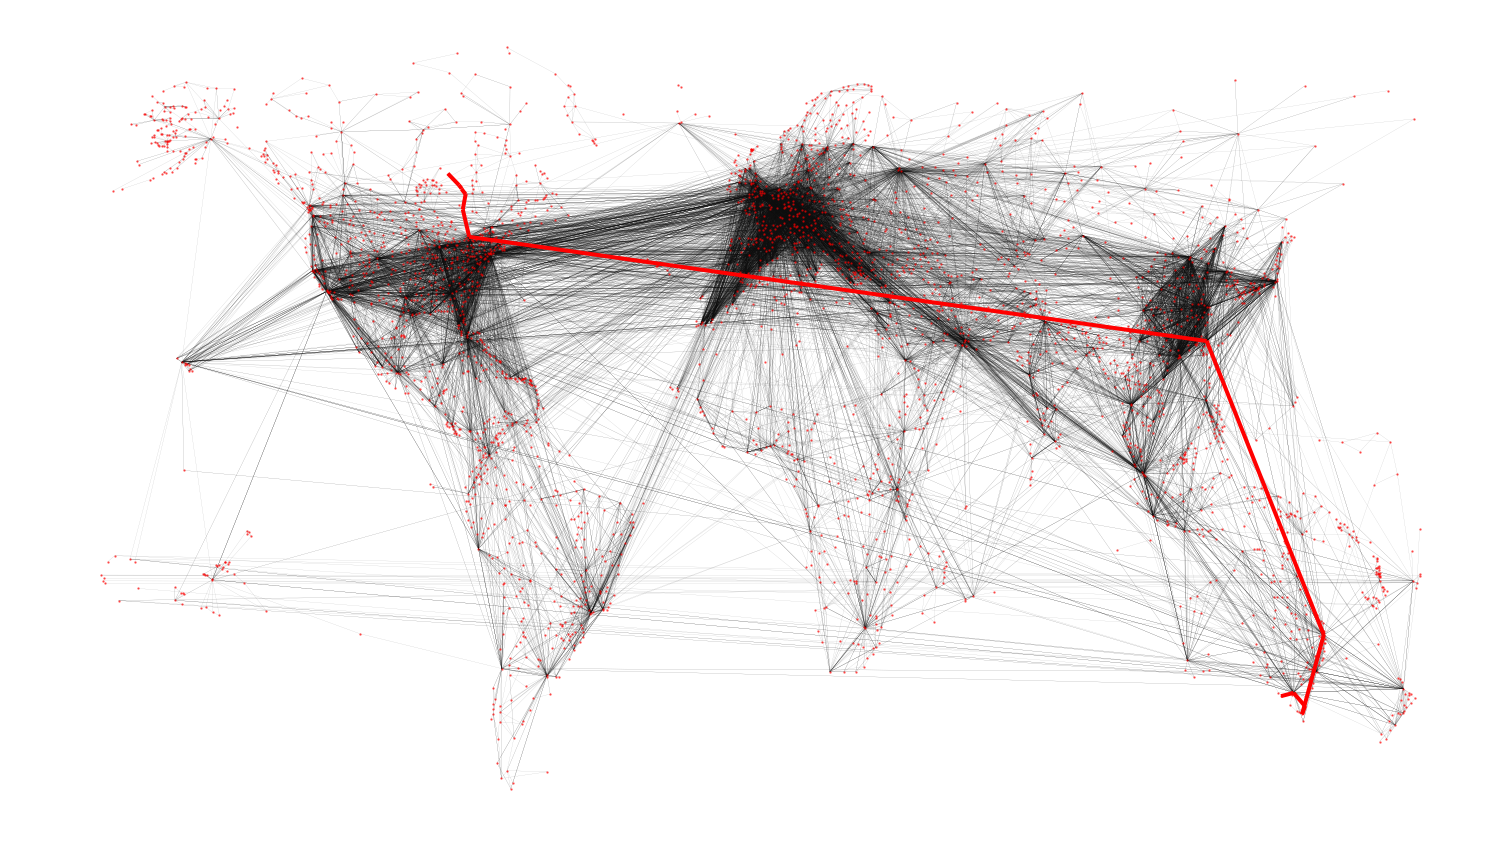

In [61]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_undirected, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))
nx.draw_networkx_edges(airport_undirected,positions, edgelist=edgeys, width = 4, alpha = 1, edge_color='r')
plt.axis('off')
fig.show()

Here the longest trip, in terms of number of airports, can be seen. 12 connecting flights

In [377]:
fig.savefig("output/longest_shortest_path.png",transparent=True,bbox_inches='tight')

In [12]:
d = dict(nx.degree(big_subgraph))

## Node size in terms of node degree

C:\Users\linde\Anaconda2\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


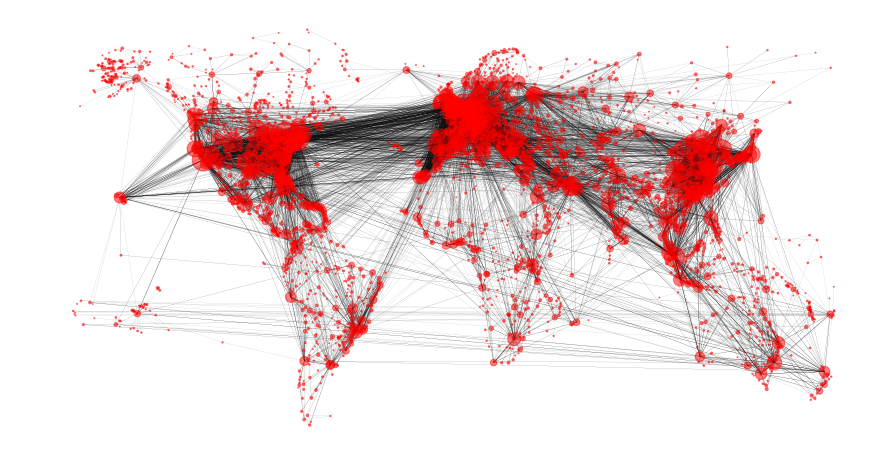

In [15]:
fig_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 1 for v in d.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_degree.show()

With many flight routes across the Atlantic, it is not very surprising that lots of the airports in Europe and the Americas have rather high degrees. With so many airports in Europe, it is hard to detect specific airports with high degree. On the west coast of the US, it is possible to detect LAX (Los Angeles International Airport), a very large airport which have many international flights to Europe and national flights around the US.

In [372]:
fig_degree.savefig("output/graph_degree_size.png",transparent=True,bbox_inches='tight')

## Node size in terms of betweenness centrality

In [16]:
bc = nx.betweenness_centrality(big_subgraph)
fig_betweeness = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 7000 for v in bc.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_betweeness.show()

KeyboardInterrupt: 

Here we see the graph, plotting the nodes' sizes in terms of there betweenness centrality. Here LAX is visible again, more clearly, and it also shows lots of the european airports have high betweeness centrality. Interestingly, one airport in Alaska have a rather high betweenness centrality, which one would think is because this airport connects the rest of the smaller Alaskan airports to the rest of the world. There are also a few airports over in the east (China, Japan and Australia) which stand alone with a rather high betweenness centrality. This indicates that these airports connects there respective areas to the rest of the world.

In [373]:
fig_betweeness.savefig("output/graph_betweeness_centrality.png",transparent=True,bbox_inches='tight')

## Node size in terms of eigenvector centrality

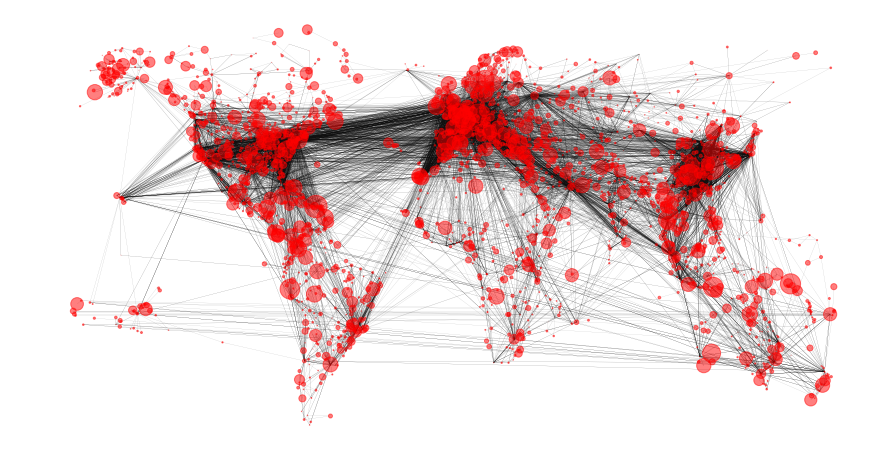

In [62]:
ec = nx.eigenvector_centrality(nx.Graph(big_subgraph))
fig_eigen = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 3000 for v in ec.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_eigen.show()

The eigenvector centralities lightens up the world, making the nodes brighten up. This indicates that the world's airports are very connected, easily giving lots of the different airports high scores in terms of eigenvector centrality.

In [63]:
fig_eigen.savefig("output/graph_eigenvector_centrality.png",transparent=True,bbox_inches='tight')

## Airports with the most connections (highest degree)

To get a view of the airports with the highest degrees, ie get an understanding of which airports are most connected, the top 10 airports in terms of degree is listed below.

In [55]:
top_airports_degree = sorted(d.iteritems(),key = lambda (k,v):(v,k),reverse=True)[:10]
for ai,de in top_airports_degree:
    print "Airport: " +  airports_by_iata_df.get_group(ai).iloc[0]['Name'] ", Degree: " + str(de)

('Hartsfield Jackson Atlanta International Airport', 932)
("Chicago O'Hare International Airport", 557)
('Charles de Gaulle International Airport', 535)
('London Heathrow Airport', 529)
('Beijing Capital International Airport', 523)
('Los Angeles International Airport', 506)
('Frankfurt am Main International Airport', 498)
('Amsterdam Airport Schiphol', 475)
('Dallas Fort Worth International Airport', 474)
('John F Kennedy International Airport', 459)


By far the airport with the highest degree is Hartsfield Jackson Atlanta International Airport, an airport used heavily for especially 

## Airports with the highest betweeness centrality

In [56]:
top_airports_betweenness = sorted(bc.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, be in top_airports_betweenness:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], be)

('Charles de Gaulle International Airport', 0.06511799752869661)
('Los Angeles International Airport', 0.06257423899066704)
('Dubai International Airport', 0.060623094185427155)
('Ted Stevens Anchorage International Airport', 0.05971268196841229)
('Frankfurt am Main International Airport', 0.054207303086621)
('Amsterdam Airport Schiphol', 0.05189224635823235)
('Beijing Capital International Airport', 0.04843164671050269)
("Chicago O'Hare International Airport", 0.047283166023850125)
('Lester B. Pearson International Airport', 0.04612367798334807)
('Atat\xfcrk International Airport', 0.04374701757809472)


Besides the more famous and busy international airports, which also was present in the airports with highest degree, one can also see the outlier of Ted Stevens Anchorage International Airport. This airport, as mentioned before is placed in Alaska, and has the task of connecting many of the Alaskan airports to the rest of the world, resulting in this airport having a large betweenness centrality.

## Airports with the highest eigenvector centralities

In [57]:
top_airports_eigenvector = sorted(ec.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, ee in top_airports_eigenvector:
    print (airports_by_iata_df.get_group(ai).iloc[0]['Name'], ee)

('Amsterdam Airport Schiphol', 0.16807029224473813)
('Frankfurt am Main International Airport', 0.16664054046814633)
('Charles de Gaulle International Airport', 0.16004376555719468)
('Munich International Airport', 0.14886703903632956)
('Leonardo da Vinci\x96Fiumicino Airport', 0.13664266408801487)
('London Heathrow Airport', 0.13600007575946021)
('Atat\xfcrk International Airport', 0.12859353718754477)
('Barcelona International Airport', 0.12847701290238536)
('Z\xfcrich Airport', 0.12595211825232527)
('Adolfo Su\xe1rez Madrid\x96Barajas Airport', 0.1236804346589473)


# Analysis of graph i terms of sentiment

In [17]:
Airport_Name_IATA = {}
for _,row in airports_df.iterrows():
    Airport_Name_IATA[row['Name']] = row['IATA']

In [18]:
import unicodecsv as csv
import codecs
'''
def unicode_csv_reader(utf8_data, dialect=csv.excel, **kwargs):
    csv_reader = csv.reader(utf8_data,delimiter='\t', dialect=dialect, **kwargs)
    for row in csv_reader:
        yield [unicode(cell, 'utf-8') for cell in row]
'''
sentiment_dict= {}
with open("output/airport_sentiment.csv") as csv_file:
    csv_reader = csv.reader(csv_file,delimiter='\t',encoding='utf-8')
    linecount = 0
    for row in csv_reader:         
        
        if linecount != 0 and row[0] in Airport_Name_IATA:
            iata = Airport_Name_IATA[row[0]]
            if iata in big_subgraph.nodes():
                sentiment_dict[iata] = float(row[1])
        linecount += 1
        

C:\Users\linde\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  from ipykernel import kernelapp as app


In [139]:
print sentiment_dict

{'AGN': 6.455609055389056, 'AGF': 6.305501541514042, 'AGB': 5.866761416083915, 'AGA': 5.88622101010101, 'NYU': 6.312547619602619, 'NYK': 6.240201832611834, 'NYI': 5.908377546897547, 'NYO': 6.160867331002331, 'AGX': 6.303243716283716, 'XBE': 6.111812041847043, 'AGT': 6.5087462925962924, 'AGS': 6.186918755688755, 'AGR': 6.19101038961039, 'KYK': 6.47832476967477, 'SRY': 6.342522366522365, 'BWT': 6.383225152347653, 'SPP': 6.32573937846665, 'KYA': 6.024474992229991, 'SPS': 6.260418863913864, 'SPU': 6.517156106116106, 'BWA': 6.295590382950385, 'PKA': 6.580696269841272, 'SPN': 6.829506937506937, 'BWI': 6.196931796536797, 'SPC': 5.919683549783549, 'SPD': 6.1883853896103895, 'BWN': 6.184725432900432, 'IXJ': 6.185260165945167, 'IXL': 6.176845086580086, 'IXM': 6.277453716283715, 'IXB': 6.166346132756133, 'IXC': 6.194449783549785, 'IXA': 6.359321349206349, 'IXG': 6.3605800396825405, 'IXD': 6.19101038961039, 'IXE': 6.277453716283715, 'IXZ': 6.268843001998001, 'BYO': 6.367097505272506, 'NYT': 6.4454

In [19]:
sentiment_mean = mean(sentiment_dict.values())
sentiment_min = min(sentiment_dict.values())
sentiment_max = max(sentiment_dict.values())
print sentiment_mean
print sentiment_min
print sentiment_max

6.258366111588227
5.60516568543
6.82950693751


In [20]:
color_map = []
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)

for n in sentiment_dict.values():
    if n <= sentiment_mean:
        color_map.append(convert_to_hex([1,(sentiment_mean-sentiment_min)-(sentiment_mean-n),(sentiment_mean-sentiment_min)-(sentiment_mean-n)]))
    else:
        color_map.append(convert_to_hex([(sentiment_max-sentiment_mean)-(n-sentiment_mean),1,(sentiment_max-sentiment_mean)-(n-sentiment_mean)]))

## Most positive airports

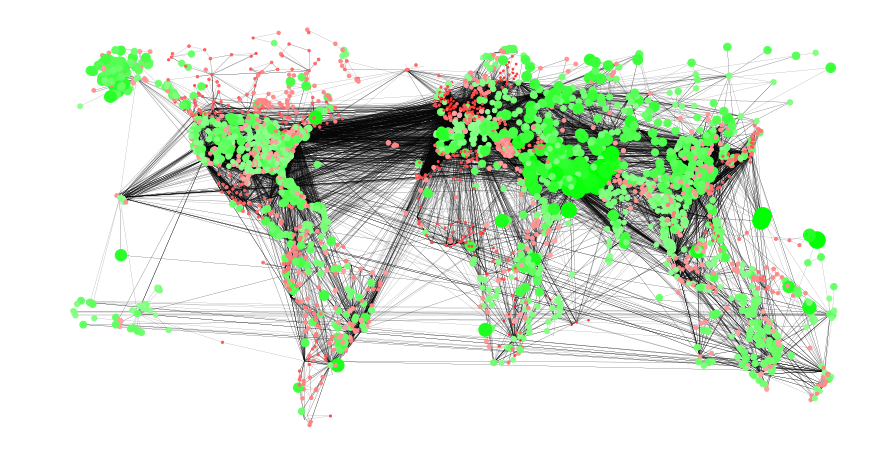

In [21]:
fig_positive = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 100**(v - sentiment_min) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive.show()

Surprisingly it seems that the airports with the highest sentiment is placed in the Middle East. This could because of the large economies which have financed these airports. More over, airports in Alaska also seem to have a high sentiment.

In [378]:
fig_positive.savefig("output/graph_positive_sentiment_airports.png",transparent=True,bbox_inches='tight')

## Most negative airports

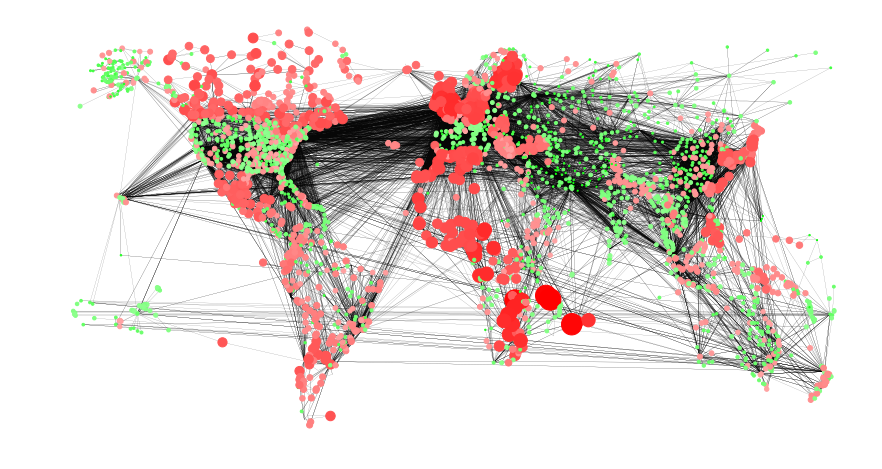

In [299]:
fig_negative = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 150**(sentiment_max - v) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative.show()

Here we see that alot of the airports in nothern and southern Europe have very low sentiments and joining them are a few airports off the coast of Africa.

In [379]:
fig_negative.savefig("output/graph_negative_sentiment_airports.png",transparent=True,bbox_inches='tight')

## Negative airports with high degree

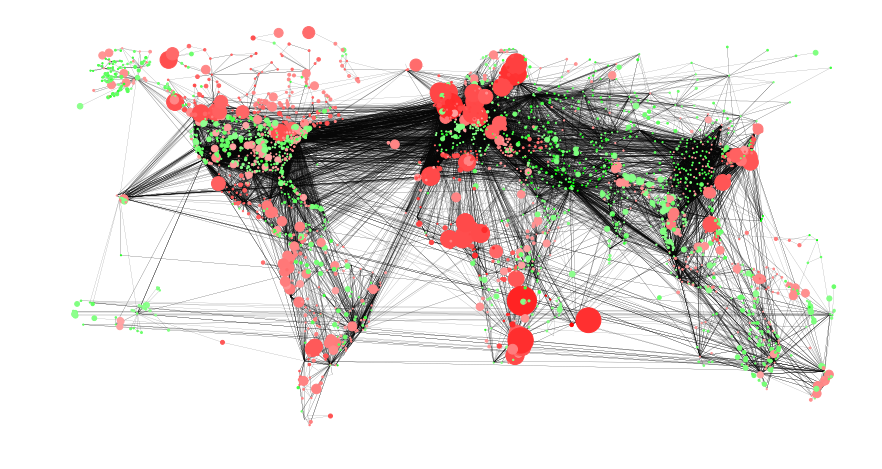

In [26]:
fig_negative_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500**(((sentiment_max - v))/d[k]) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative_degree.show()

In [380]:
fig_negative_degree.savefig("output/graph_negative_sentiment_degree_airports.png",transparent=True,bbox_inches='tight')

## Positive airports with high degree

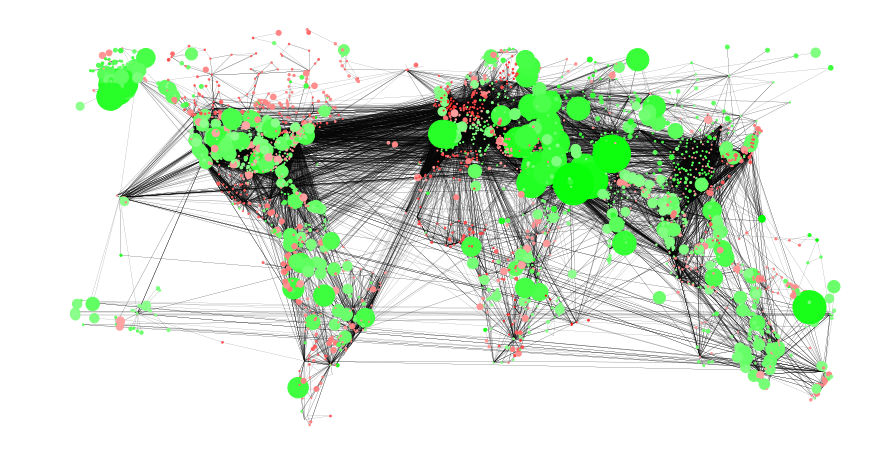

In [25]:
fig_positive_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500**(((v - sentiment_min))/d[k]) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive_degree.show()

In [381]:
fig_positive_degree.savefig("output/graph_positive_sentiment_degree_airports.png",transparent=True,bbox_inches='tight')

## Absolute sentiment

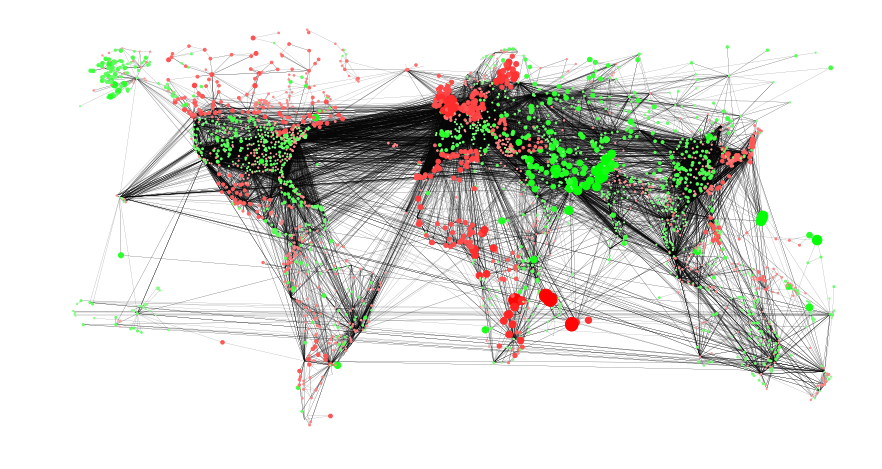

In [271]:
fig_absolute = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 3000**abs(v - sentiment_mean) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute.show()

Here we see the negative and positive sentimented airports joined in one plot.

In [382]:
fig_absolute.savefig("output/graph_absolute_sentiment.png",transparent=True,bbox_inches='tight')

## Absolute sentiment vs. degree

In [37]:
max_degree = max(d.values())

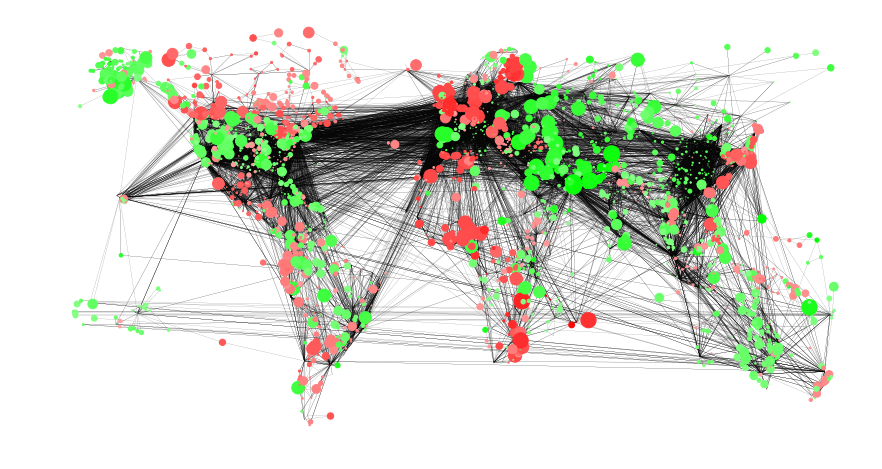

In [36]:
fig_absolute_degree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500*((abs(v - sentiment_mean)/d[k]**2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_degree.show()

In [383]:
fig_absolute_degree.savefig("output/graph_absolute_sentiment_degree.png",transparent=True,bbox_inches='tight')

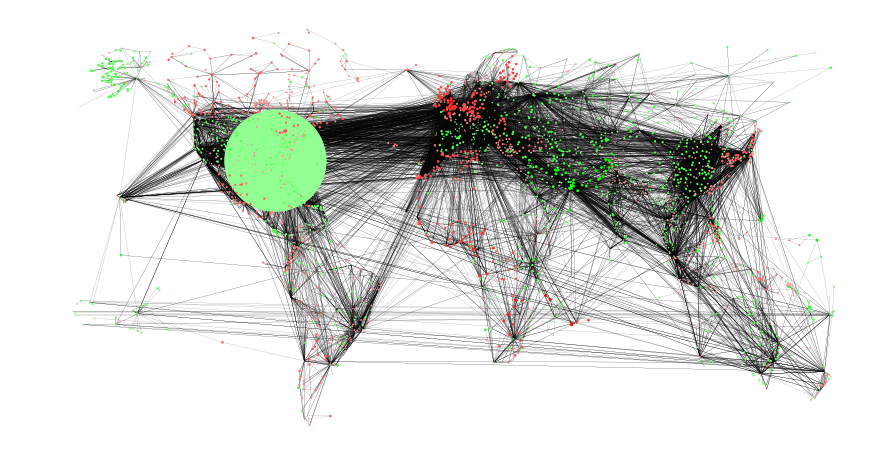

In [46]:
fig_absolute_mindegree = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 5000000*((abs(v - sentiment_mean)/(max_degree-d[k]+1)**2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_mindegree.show()

In [384]:
fig_absolute_mindegree.savefig("output/graph_absolute_sentiment_min_degree.png",transparent=True,bbox_inches='tight')

## Absolute sentiment vs. lattitude and longitude

In [48]:
airport_iata_latitude = {}
airport_iata_longitude = {}
for _,row in airports_df.iterrows():
    airport_iata_latitude[row['IATA']] = row['Latitude']
    airport_iata_longitude[row['IATA']] = row['Longitude']

### Near the equator

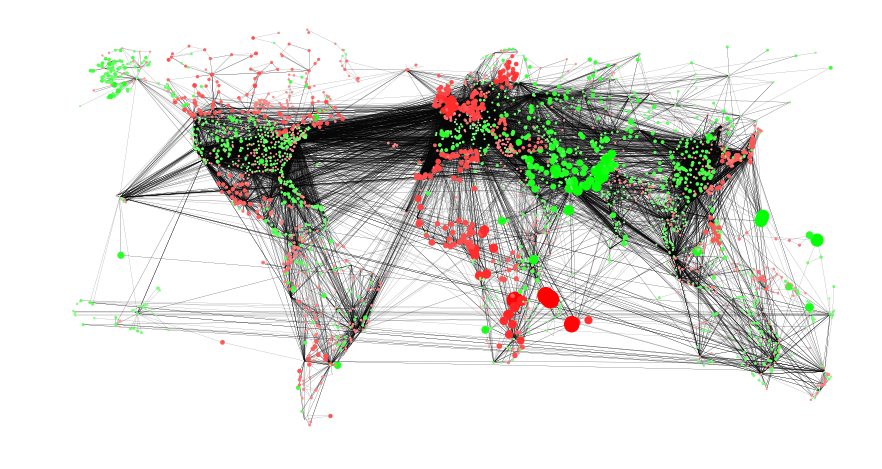

In [54]:
fig_absolute_latitude_equator = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((90-abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_equator.show()

In [385]:
fig_absolute_latitude_equator.savefig("output/graph_absolute_latitude_equator.png",transparent=True,bbox_inches='tight')

### Near the poles

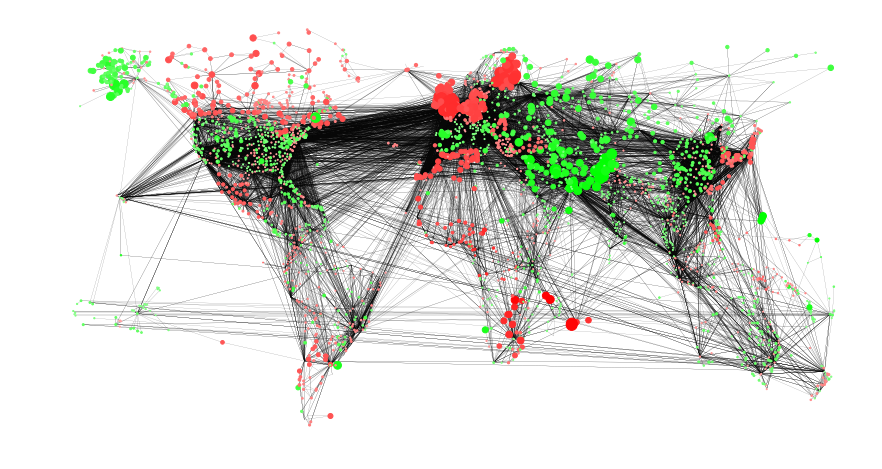

In [356]:
fig_absolute_latitude_poles = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2.5)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_poles.show()

In [386]:
fig_absolute_latitude_poles.savefig("output/graph_absolute_latitude_poles.png",transparent=True,bbox_inches='tight')

### Middle longitude

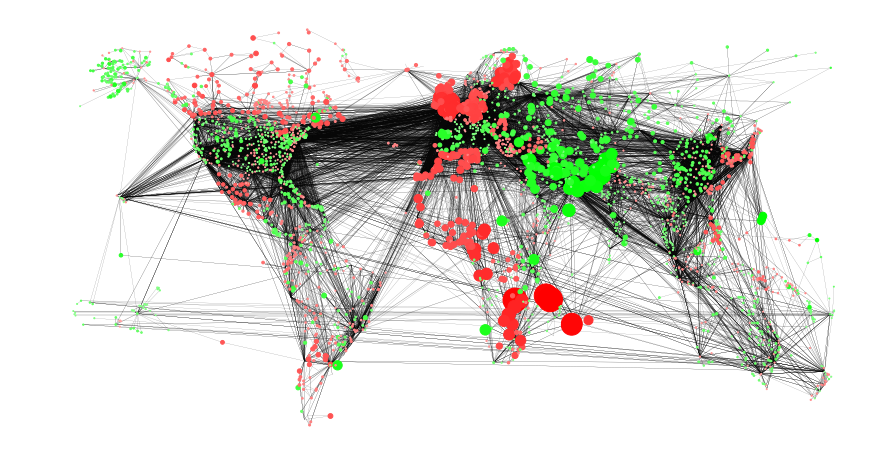

In [366]:
fig_absolute_longitude_zero = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((180-abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_zero.show()

In [387]:
fig_absolute_longitude_zero.savefig("output/graph_absolute_longitude_zero.png",transparent=True,bbox_inches='tight')

### Away from middle longitude (?? what)

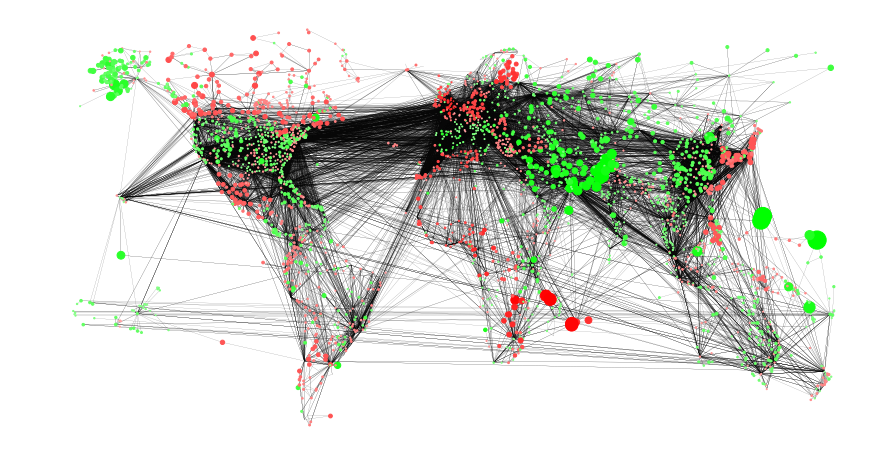

In [368]:
fig_absolute_longitude_nonzero = plt.figure(figsize=[15,8])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_nonzero.show()

In [388]:
fig_absolute_longitude_nonzero.savefig("output/graph_absolute_longitude_nonzero.png",transparent=True,bbox_inches='tight')